### Einleitung

Dieses Notebook soll zeigen, wie eine Basisanalyse der Daten aus dem NHANES-Datensatz aussehen könnte. Ziel ist es, die Daten für weiterführende Analysen bzw. das Training von ML-Modellen aufzubereiten. Dazu werden die Daten unter verschiedenen Gesichtspunkten analysiert. Für die dabei identifizierten Auffälligkeiten diskutieren wir Lösungsmöglichkeiten. Das Notebook gliedert sich in folgende Abschnitte:

- [Benötigte Pakete laden](#Benötigte-Pakete-laden)
- [Erster Blick in die Daten](#Erster-Blick-in-die-Daten)
- [Analyse von Sterbealtern](#Analyse-von-Sterbealtern)
- [Korrelation Sterbealter mit anderen Variablen](#Korrelation-Sterbealter-mit-anderen-Variablen)
- [Analyse von Sterbealtern im Zeitverlauf](#Analyse-von-Sterbealtern-im-Zeitverlauf)
- [Mapping von Todesaltern auf Zweijahreszeiträume](#Mapping-von-Todesaltern-auf-Zweijahreszeiträume)
- [Detailanalyse der einzelnen Merkmale](#Detailanalyse-der-einzelnen-Merkmale)
- [Suche nach Ausreißern](#Suche-nach-Ausreißern)

### Benötigte Pakete laden

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()

### Erster Blick in die Daten

In [2]:
df = pd.read_csv("../NHANES_ORIGINAL/data/NHANES_ALL.csv")
df.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,19,20,21,22,41,42,44,49,50,51,52,53,54,55,56,57,58,59) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(65018, 77)

Wir haben rund 65.000 Beobachtungen mit 77 Merkmalen.

In [3]:
df.head()

,SEQN,Phase,Cycle,Study,SampleWeightMEC,Gender,AgeDOS,Tot_Income_family,Educational_Level_20plus,Marital_status,...,diabetes,hyperten,permth_int,permth_exm,ID,yearDOS,yearDOB,Death,Surv,yearDOE
0,3,1.0,1,NHANES III,193.064444,Male,21,$5000 to $9999,High School Grad/GED or equivalent,Never married,...,NaN,NaN,293,293.0,33,1990,1969,0,293,2014
1,4,1.0,1,NHANES III,192.247778,Female,32,Over $50000,College Graduate or above,Married,...,NaN,NaN,317,316.0,34,1990,1958,0,316,2016
2,9,1.0,1,NHANES III,2169.040000,Female,48,Over $50000,College Graduate or above,Married,...,NaN,NaN,293,293.0,39,1990,1942,0,293,2014
3,10,1.0,1,NHANES III,3120.063333,Male,35,$45000 to $49999,College Graduate or above,Living with partner,...,NaN,NaN,306,306.0,310,1990,1955,0,306,2015
4,11,1.0,1,NHANES III,138.714444,Male,48,$25000 to $34999,Less than 9th grade,Married,...,Yes,No,206,206.0,311,1990,1942,1,206,2007


Wir können prüfen, ob es Merkmale gibt, die nur eine Ausprägung haben. Diese sind für ML-Modelle ohne jeglichen Informationsgehalt.

In [4]:
var_eine_auspraegung = []
for c in df.columns:
    n = len(df[c].value_counts())
    if n == 1:
        var_eine_auspraegung.append(c)
var_eine_auspraegung

['eligstat']

Die Spalte **eligstat** kann also aus dem Datensatz entfernt werden. Schauen wir uns an, welche Spalten am schlechtesten befüllt sind...

In [5]:
missing = df.isnull().sum()
missing/=len(df)
missing.sort_values(ascending = False, inplace = True)
missing.head(20)

total_fat_monounsat                 1.000000
total_fat_polyunsat                 1.000000
total_fat                           1.000000
total_fat_sat                       1.000000
total_fiber                         1.000000
Estimated_VO2MAX                    0.931957
Cardiovascular_fitness_level        0.931957
STEPS                               0.925805
Predicted_VO2MAX                    0.916377
LDL                                 0.891784
Industry                            0.860485
Occupation                          0.860269
INTENSITY_MINUTES                   0.852502
hyperten                            0.797933
diabetes                            0.797933
ucod_leading                        0.797933
Cover_any_single_plan               0.797748
Cover_other_government_insurance    0.797748
plasGluMMOL                         0.755975
plasGluMG                           0.755975
dtype: float64

Viele Merkmale sind sehr schlecht befüllt. Bei fünf Variablen liegen überhaupt keine Informationen vor. Diese können bei weiterführenden Analysen ebenfalls aus dem Datensatz entfernt werden.

<AxesSubplot:>

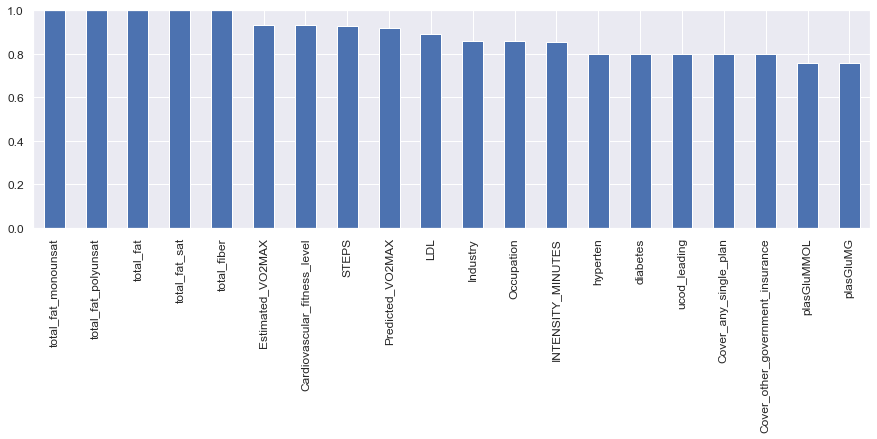

In [6]:
missing.head(20).plot(kind="bar", rot=90, figsize=(15,4), fontsize = 12, ylim=(0,1))

In [7]:
df.drop(["eligstat", "total_fat_monounsat", "total_fat_polyunsat", "total_fat", "total_fiber", "total_fat_sat"], axis = 1, inplace=True)

### Analyse von Sterbealtern

Schauen wir uns unsere Zielgröße etwas genauer an ...

In [8]:
df["Death_Year"] = np.where(df["Death"]==1, df["yearDOE"],0)
df["Death_Age"] = np.where(df["Death"]==1, df["Death_Year"] - df["yearDOB"], 0)

Wie sind die Sterbealter verteilt?

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Verteilungsschiefe: -1.18 / Verteilungswölbung: 1.08'}, xlabel='Death_Age', ylabel='Density'>

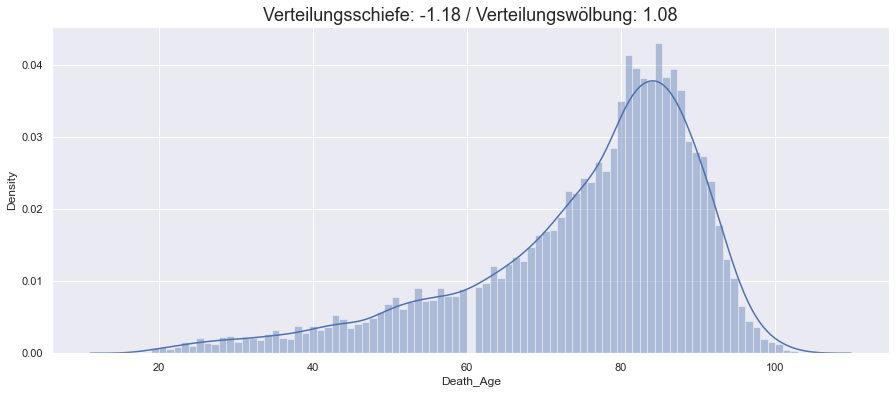

In [9]:
plt.figure(figsize=(15,6))
df_cut=df["Death_Age"][df["Death_Age"]>17]
plt.title("Verteilungsschiefe: {0:.2f} / Verteilungswölbung: {1:.2f}".format(df_cut.skew(), df_cut.kurtosis()),
          fontsize = 18)
sns.distplot(df_cut, bins=df["Death_Age"].nunique())

Unsere Zielvariable ist linksschief und könnte daher vor Anwendung von Machine-Learning-Verfahren z. B. durch $$ln(max(Sterbealter) + 1 - Sterbealter)$$ transformiert werden, in der Hoffnung, dass die transformierte Verteilung eher einer Normalverteilung entspricht. Wir probieren mal, wie das aussehen würde:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Verteilungsschiefe: -0.21 / Verteilungswölbung: 0.62'}, xlabel='Death_Age', ylabel='Density'>

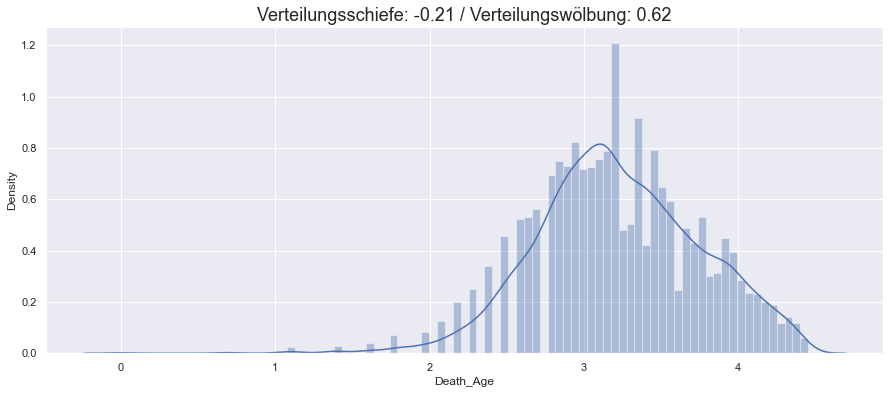

In [10]:
plt.figure(figsize=(15,6))
df_cut = np.log(max(df_cut) + 1 - df_cut)
plt.title("Verteilungsschiefe: {0:.2f} / Verteilungswölbung: {1:.2f}".format(df_cut.skew(), df_cut.kurtosis()),
          fontsize = 18)
sns.distplot(df_cut, bins = df["Death_Age"].nunique())

Anhand von Schiefe und Wölbung der beiden Verteilungen ist klar, dass die transformierte Verteilung deutlich näher an einer Normalverteilung ist.

### Korrelation Sterbealter mit anderen Variablen
Wir wollen untersuchen, wie das Sterbealter mit den anderen (numerischen) Variablen korreliert ist. Vorab müssen wir uns jedoch um die numerischen Variablen kümmern. Manche werden von Python irrtümlich als Text interpretiert. Das liegt daran, dass als Trennzeichen ein Komma verwendet wird. Python benötigt als Trennzeichen aber einen Punkt. Das wandeln wir um.

In [11]:
maybe_num_columns = [x for x in df.columns.values if len(df[x].unique())>30]
maybe_num_columns = list(set(maybe_num_columns) - set(["SEQN", "DOB", "DOE", "Occupation", "Industry", "SEQN_neu"]))

for col in maybe_num_columns:
    if df[col].dtype=="object":
        df[col] = df[col].str.replace(",", ".").astype(float)

Nach der Konvertierung filtern wir die numerischen Variablen aus dem Datensatz heraus und plotten für diese jeweils einen Scatterplot. Wie wir später bei den [Detailanalysen](#Suche-nach-Ausreißern) sehen werden, gibt es bei bestimmten Variablen einige Ausreißer. Wir schneiden daher für die Plots die Ränder der Verteilung ab - jeweils beim 1%- bzw. 99%-Quantil.

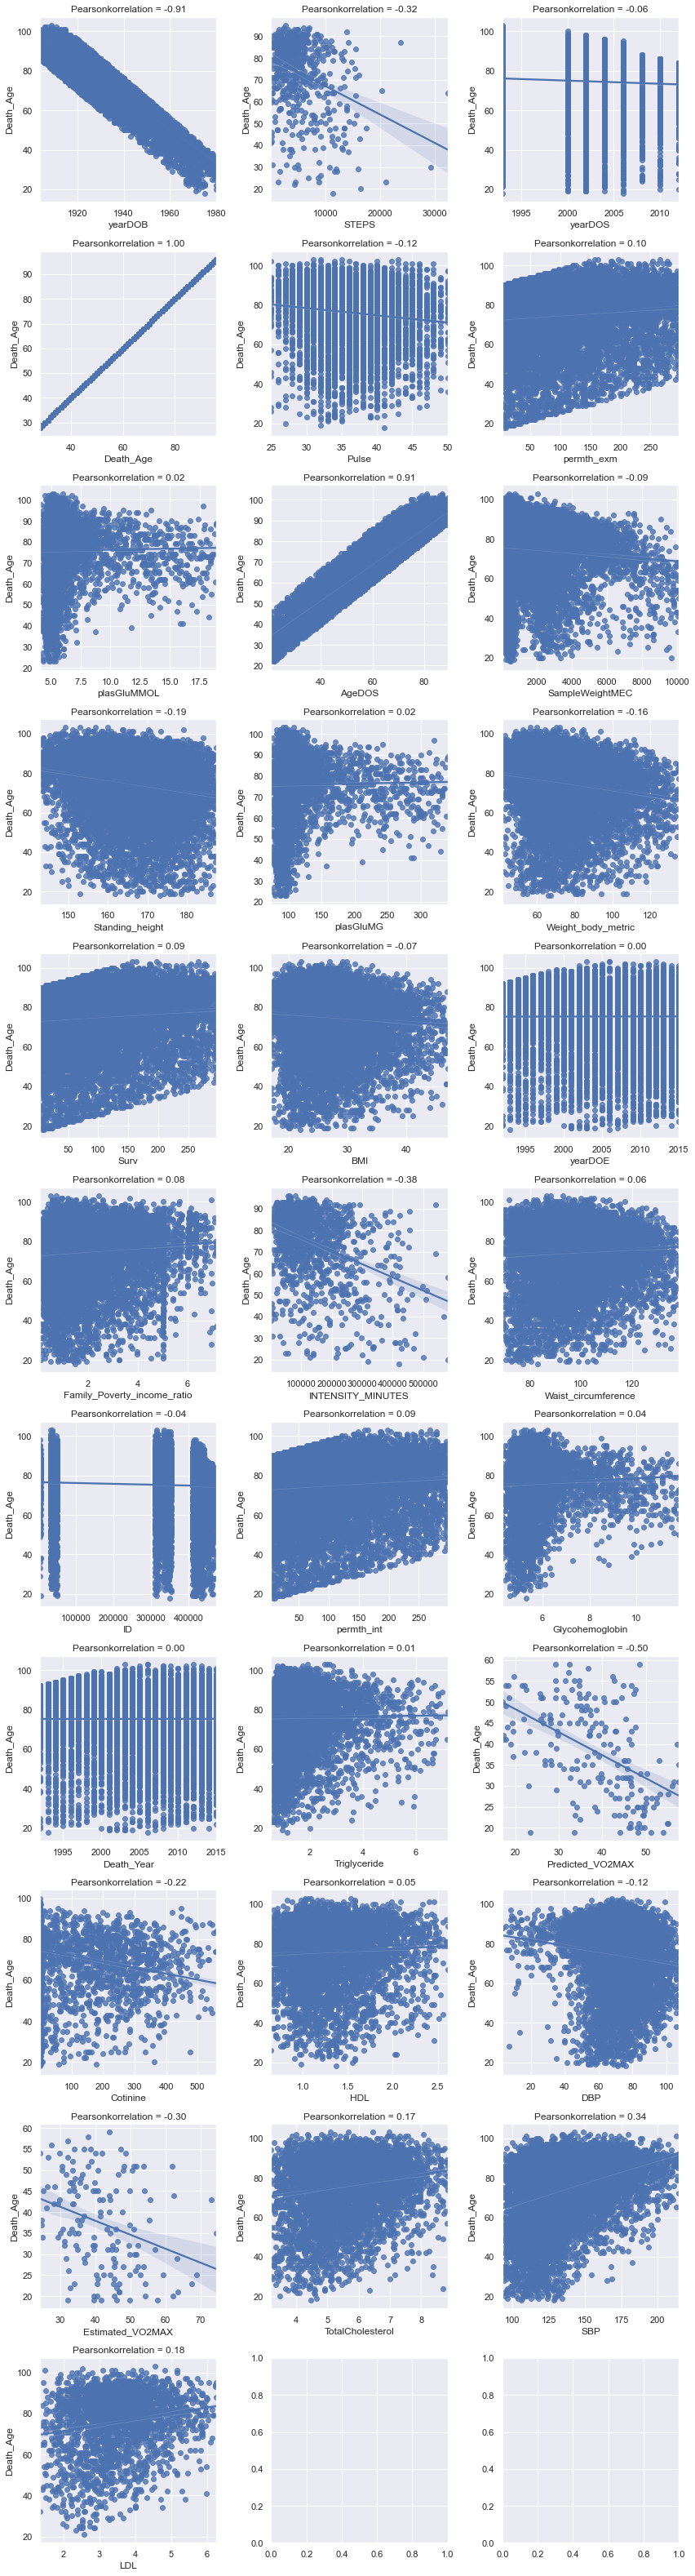

In [12]:
df_cut = df[df["Death"]==1]
numerical_feat = list(df_cut.dtypes[df_cut.dtypes != "object"].index)
numerical_feat = list(set(numerical_feat) - set(["SEQN", "CAUSE", "Phase", "SI", "Death", "train"]))

n_rows = 11
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize = (n_cols*4, n_rows*4))

for r in range(0,n_rows):
    for c in range(0, n_cols):
        i = r*n_cols + c
        if i<len(numerical_feat):
            daten = df_cut[numerical_feat[i]]
            maske = daten[~daten.isnull()][daten>daten.quantile(0.01)][daten<daten.quantile(0.99)].index
            #sns.regplot(daten[maske], df_cut["Death_Age"][maske], ax= axs[r][c])
            if len(daten[maske])>0:
                sns.regplot(x=daten[maske], y=df_cut["Death_Age"][maske], ax=axs[r][c])
                stp = stats.pearsonr(daten[maske], df_cut["Death_Age"][maske])
                axs[r][c].set_title("Pearsonkorrelation = " + "{0:.2f}".format(stp[0]))
            else:
                axs[r][c].set(xlabel=numerical_feat[i])
                axs[r][c].text(0.5,0.5,"Zu wenige Daten", horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

Es gibt einige Variablen, die eine stärkere Korrelation zum Sterbealter aufweisen:

----- keine Überraschung, da altersbezogen -----
- yearDOB
- AgeDOS


----- starke Korrelation, aber nur bei geringem Anteil der Datensätze befüllt -----
- Predicted_VO2MAX
- Estimated_VO2MAX
- Steps
- Intensity Minutes


----- weitere Variablen mit stärkerer Korrelation -----
- Cotinine
- Standing_Height
- SBP
- TotalCholesterol
- Weight_body_metric


Die Variablen der letzten beiden Blöcke sind vielversprechende Kandidaten, wenn man ML-Modelle nicht auf dem gesamten Datensatz trainieren möchte.

### Analyse von Sterbealtern im Zeitverlauf
Schauen wir uns noch an, wie das Sterbealter und das Sterbejahr zusammenhängen. Dafür zählen wir, wie häufig die einzelnen Kombinationen aus Sterbealter und Sterbejahr vorkommen.

In [13]:
df_sc = df[df["Death"]==1][["Death_Year", "Death_Age", "SEQN"]].groupby(["Death_Year", "Death_Age"]).size()
df_sc = df_sc.rename("count").reset_index()
df_sc.head()

,Death_Year,Death_Age,count
0,1990,19,1
1,1990,22,1
2,1990,23,1
3,1990,29,1
4,1990,31,1


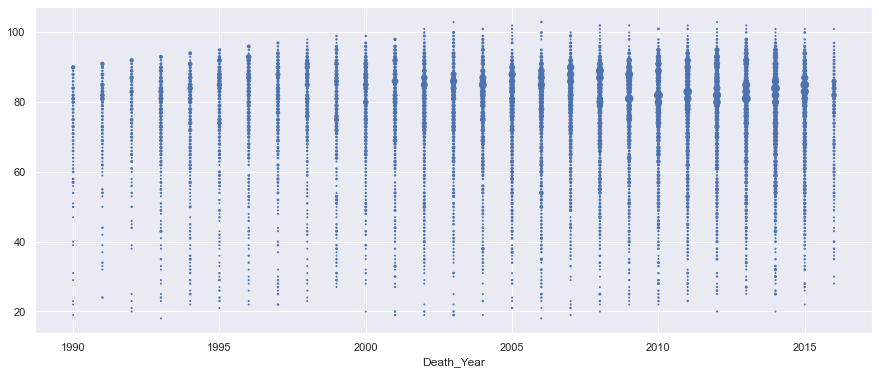

In [14]:
plt.figure(figsize=(15,6))
plt.xlabel("Death_Year", fontsize=12)
plt.scatter(df_sc["Death_Year"], df_sc["Death_Age"], s=df_sc["count"])

Man sieht einen schönen Trend im Höchstalter von 1990 bis ca. 2003. Die meisten Daten zu Todesfällen scheint es aus den Jahren ab 2000 zu geben. Auffällig ist, dass sich Alter mit vielen Todesfällen oft mit Altern mit wenigen Todesfällen abwechseln (gezoomter Ausschnitt aus der Grafik):
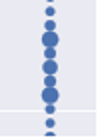

In der folgenden Heatmap für die Sterbefälle ab 70 Jahren sieht man diese 2-Jährigkeit auch sehr gut.

<AxesSubplot:xlabel='Death_Age', ylabel='Death_Year'>

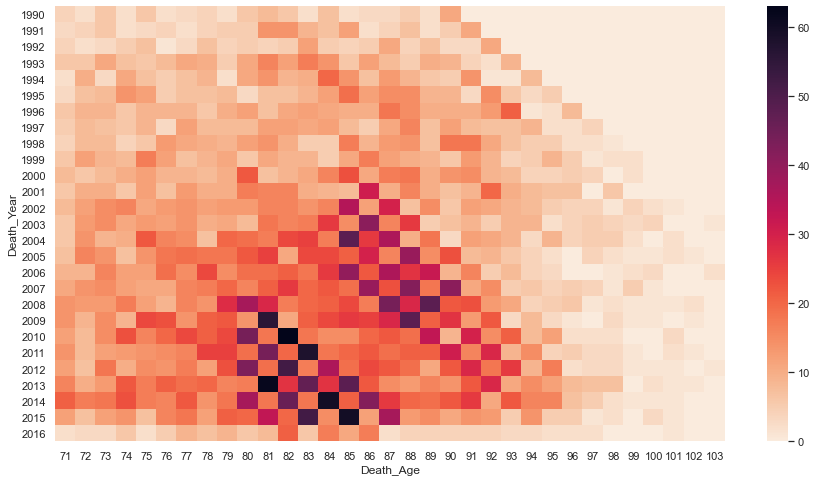

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(df_sc[df_sc["Death_Age"]>70].pivot(index="Death_Year", columns="Death_Age", values="count").fillna(0),
            cmap = "rocket_r")

Die 2-Jährigkeit bei den Sterbefällen ist höchstwahrscheinlich dem 2-Jahres-Rhythmus der NHANES-Studie geschuldet. Es ist zu überlegen, ob für die Sterblichkeitsmodellierung jeweils zwei Jahre zusammengefasst werden sollten...

### Mapping von Todesaltern auf Zweijahreszeiträume

In [16]:
bins = {i: i-i%2 for i in range(min(df_sc["Death_Age"]), max(df_sc["Death_Age"])+1)}
df_sc["Death_Age_2y"] = df_sc["Death_Age"].replace(bins)

In [17]:
df_sc_2y = df_sc.drop("Death_Age", axis=1).groupby(["Death_Year", "Death_Age_2y"]).sum().reset_index()

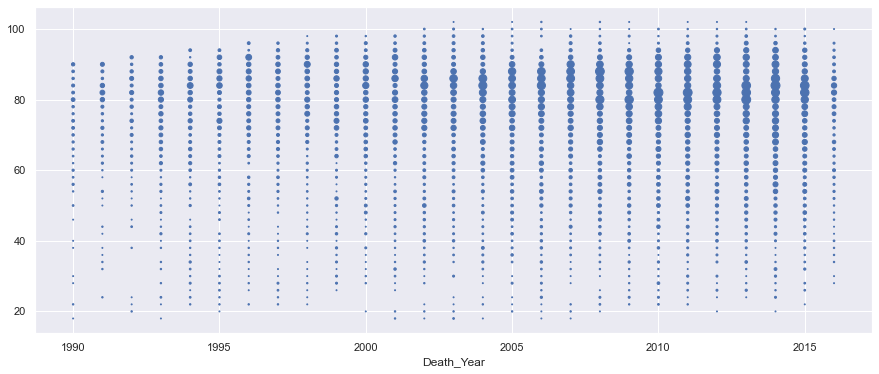

In [18]:
plt.figure(figsize=(15,6))
plt.xlabel("Death_Year", fontsize=12)
plt.scatter(df_sc_2y["Death_Year"], df_sc_2y["Death_Age_2y"], s=df_sc_2y["count"])

<AxesSubplot:xlabel='Death_Age_2y', ylabel='Death_Year'>

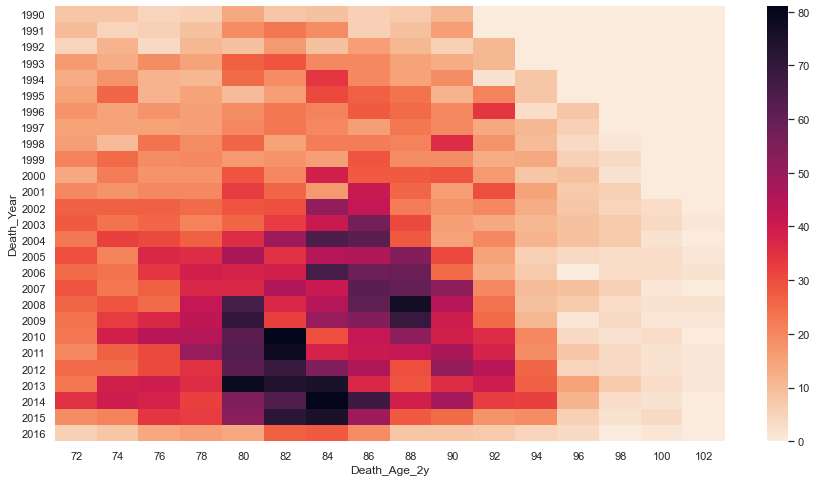

In [19]:
plt.figure(figsize=(15,8))
sns.heatmap(df_sc_2y[df_sc_2y["Death_Age_2y"]>70].pivot(index="Death_Year", columns="Death_Age_2y", values="count").fillna(0),
            cmap = "rocket_r")

Anhand der Grafiken lässt sich schön sehen, dass die Verteilung der Sterbealter bei Betrachtung der Zweijahreszeiträume deutlich glatter ist.

### Detailanalyse der einzelnen Merkmale
Wir schauen uns die einzelnen Merkmale des Datensatzes im Detail an. Dazu lassen wir uns für alle Merkmale die Anzahl der verschiedenen Ausprägungen ausgeben und prüfen, ob es hier Auffälligkeiten gibt.

In [20]:
for merkmal in df.columns.values:
    print("~~ " + merkmal + " ~~")
    print(df[merkmal].value_counts())
    print(20*"-")

~~ SEQN ~~
4094     2
35968    2
32254    2
22011    2
40002    2
        ..
7252     1
5205     1
29785    1
27738    1
14375    1
Name: SEQN, Length: 54957, dtype: int64
--------------------
~~ Phase ~~
2.0    8916
1.0    8823
Name: Phase, dtype: int64
--------------------
~~ Cycle ~~
1    8823
2    7561
F    6510
E    6219
H    6100
B    5987
G    5849
C    5610
D    5560
A    5444
2    1355
Name: Cycle, dtype: int64
--------------------
~~ Study ~~
NHANES Continuous    47279
NHANES III           17739
Name: Study, dtype: int64
--------------------
~~ SampleWeightMEC ~~
0.000000       2701
245.964444       50
861.102820       44
442.325556       38
646.024444       37
               ... 
391.901674        1
8317.224451       1
8202.643903       1
2940.183048       1
4039.576287       1
Name: SampleWeightMEC, Length: 37204, dtype: int64
--------------------
~~ Gender ~~
Female    33942
Male      31076
Name: Gender, dtype: int64
--------------------
~~ AgeDOS ~~
18    2174
19    2107


Bei der Variablen *Family_Poverty_income_ratio* fällt die Ausprägung 5 auf. Alle anderen Ausprägungen scheinen krumme Zahlen zu sein. Die 5 passt nicht in dieses Bild und kommt ziemlich häufig vor. Laut Dokumentation (https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/DEMO_D.htm#INDFMPIR) steht 5 eigentlich für "5 oder größer". Diese Information könnte man in einer gesonderten Variable festhalten. Denn für einen ML-Algorithmus haben z. B. die Ausprägungen 5 und 4,5 den gleichen metrischen Abstand wie 4,5 und 4. Doch mit dem Zusatzwissen, dass die Ausprägung bei 5 gekappt wurde, ist klar, dass der Abstand zwischen 5 und 4,5 anders gewertet werden sollte als der Abstand zwischen 4,5 und 4.  

In [21]:
print(df["Family_Poverty_income_ratio"].value_counts().head(10))
df["Family_PIR_greater_five"] = np.where(df["Family_Poverty_income_ratio"] == 5, 1,0)

5.00    7340
0.00     502
1.16     265
1.20     233
1.02     225
1.07     213
1.24     211
1.29     208
1.36     207
1.09     205
Name: Family_Poverty_income_ratio, dtype: int64


Bei *Tot_Income_family* passen die Werte nicht zusammen. Ein Blick in die Dokumentation (https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/DEMO_F.htm#INDFMIN2) zeigt, dass hier zwei Schlüssel vermischt wurden. Leider sind auch die abgefragten Einkommensintervalle über die Zeit nicht konstant geblieben. So gab es teilweise nur die Unterscheidung zwischen Einkommen unter bzw. über \\$20.000. Zudem wurde die abgefragte Obergrenze immer wieder angepasst von "\\$50.000 +" über "\\$75.000 +" zu "\\$100.000 +".

In [22]:
df["Tot_Income_family"].value_counts()

$10000 to $14999     6596
$15000 to $19999     5809
$35000 to $44999     5768
$20000 to $24999     5530
$25000 to $349999    5448
$5000 to $9999       5154
$75000 +             3501
$45000 to $54999     3481
$100000 +            3354
$0 to $4999          2923
$55000 to $64999     2430
$25000 to $34999     2277
Over $50000          2214
$65000 to $74999     2022
$75000 to $99999     1913
Over $20000          1896
Under $20000         1605
$45000 to $49999      634
Name: Tot_Income_family, dtype: int64

Wir probieren zwei Möglichkeiten aus, um dieses Merkmal zu schlüsseln und lassen die ML-Algorithmen entscheiden, welches Merkmal sie hilfreicher finden. Variante A behandelt das Einkommen als kategoriales Merkmal. Wir führen die beiden Schlüssel zusammen und nutzen dann das sogenannte One-Hot-Encoding. Dabei wird für jede Ausprägung des Schlüssels ein neues Merkmal erstellt, welches z. B. nur die Information enthält "Einkommen zwischen \\$10000 und \\$14999" - ja oder nein.

In [23]:
#Schlüssel zusammenführen
df["Tot_Income_family"].replace({"1":"$0 to $4999",
                                   "2":"$5000 to $9999",
                                   "3":"$10000 to $14999",
                                   "4":"$15000 to $19999",
                                   "5":"$20000 to $24999",
                                   "6":"$25000 to $34999",
                                   "7":"$35000 to $44999",
                                   "8":"$45000 to $54999",
                                   "9":"$55000 to $64999",
                                   "10":"$65000 to $74999",
                                   "11":"$75000 and over",
                                   "12":"Over $20000",
                                   "13":"Under $20000",
                                   "14":"$75000 to $99999",
                                   "15":"$100000 and Over",
                                   "99":"Don't know",
                                   "77":"Refused"}, inplace=True)

#$ durch USD ersetzen, da $ teilweise als Steuerzeichen interpretiert wird
df["Tot_Income_family"] = df["Tot_Income_family"].str.replace("$","USD ")

#One-Hot-Encoding
df = pd.concat([df,pd.get_dummies(df["Tot_Income_family"], prefix="Income_Fam")],axis=1)

#Ausgabe
pd.concat([df["Tot_Income_family"], df.iloc[:,-18:]], axis = 1).head()

<ipython-input-23-0a2a35470224>:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["Tot_Income_family"] = df["Tot_Income_family"].str.replace("$","USD ")


,Tot_Income_family,Income_Fam_Over USD 20000,Income_Fam_Over USD 50000,Income_Fam_USD 0 to USD 4999,Income_Fam_USD 10000 to USD 14999,Income_Fam_USD 100000 +,Income_Fam_USD 15000 to USD 19999,Income_Fam_USD 20000 to USD 24999,Income_Fam_USD 25000 to USD 34999,Income_Fam_USD 25000 to USD 349999,Income_Fam_USD 35000 to USD 44999,Income_Fam_USD 45000 to USD 49999,Income_Fam_USD 45000 to USD 54999,Income_Fam_USD 5000 to USD 9999,Income_Fam_USD 55000 to USD 64999,Income_Fam_USD 65000 to USD 74999,Income_Fam_USD 75000 +,Income_Fam_USD 75000 to USD 99999,Income_Fam_Under USD 20000
0,USD 5000 to USD 9999,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Over USD 50000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Over USD 50000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,USD 45000 to USD 49999,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,USD 25000 to USD 34999,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Wie man sieht, enthalten die neu erzeugten Spalten überall Nullen, außer bei der Spalte, die zum Einkommensintervall der Familie passt. Dort steht eine Eins.

Als zweite Variante schlüsseln wir das Einkommen als numerische Variable und versuchen eine einheitliche Metrik über die Einkommensintervalle zu legen. Die Metrik soll sich auf die Mitte der jeweligen Einkommensintervalle beziehen.

In [24]:
df["Tot_Income_family"].replace({"USD 0 to USD 4999": 2500,
                                 "USD 5000 to USD 9999": 7500,
                                 "USD 10000 to USD 14999": 12500,
                                 "USD 15000 to USD 19999": 17500,
                                 "USD 20000 to USD 24999": 22500,
                                 "USD 25000 to USD 34999": 30000,
                                 "USD 35000 to USD 44999": 40000,
                                 "USD 45000 to USD 49999": 47500,
                                 "USD 45000 to USD 54999": 50000,
                                 "USD 55000 to USD 64999": 60000,
                                 "USD 65000 to USD 74999": 70000,
                                 "USD 75000 to USD 99999": 87500,
                                 "Don't know": 0,
                                 "Refused":0}, inplace=True)

Nun müssen wir noch entscheiden, wie die halboffenen Intervalle geschlüsselt werden sollen.

Für die Kategorie "Under \\$20000" könnten wir das gewichtete Mittel der Kategorien "\\$0 to \\$4999", "\\$5000 to \\$9999", "\\$10000 to \\$14999" und "\\$15000 to \\$19999" verwenden.

Für die anderen Kategorien, wie "\\$75000 and over" bräuchten wir eine fiktive Einkommensobergrenze, um die Mitte des Intervalls bestimmen zu können. Laut Einkommensverteilung lag das 95%-Quantil in 2016 bei ca. \\$225.000 (https://dqydj.com/united-states-household-income-brackets-percentiles-2016/). Diese Zahl soll als einfacher Schätzer für die Einkommensobergrenze dienen, auch wenn sie relativ willkürlich gewählt ist.

Mit etwas Zusatzarbeit könnte man alternativ ermitteln, in welchem Erhebungszeitraum der NHANES-Studie die verschiedenen Ausprägungen, wie "\\$75000 and over" oder "Over \\$50000" genutzt wurden und dann anhand der Einkommensverteilung für diesen Zeitraum ein bestimmtes Quantil als Schätzer für die Einkommensobergrenze verwenden.

In [25]:
anz = df["Tot_Income_family"].value_counts()
Schluessel_under_20000 = (2500*anz[2500] + 7500*anz[7500] + 12500*anz[12500] +
                          17500*anz[17500])/(anz[2500] + anz[7500] + anz[12500] + anz[17500])

df["Tot_Income_family"].replace({"Under USD 20000": Schluessel_under_20000,
                                 "Over USD 20000": (225000-20000)/2,
                                 "Over USD 50000": (225000-50000)/2,
                                 "USD 75000 and over": (225000-75000)/2,
                                 "USD 75000 +": (225000-75000)/2,
                                 "USD 100000 and Over": (225000-100000)/2}, inplace=True)
df["Tot_Income_family"].value_counts()

12500                      6596
17500                      5809
40000                      5768
22500                      5530
USD 25000 to USD 349999    5448
7500                       5154
87500.0                    4127
75000.0                    3501
50000                      3481
USD 100000 +               3354
2500                       2923
60000                      2430
30000                      2277
70000                      2022
102500.0                   1896
11232.789766624353         1605
47500                       634
Name: Tot_Income_family, dtype: int64

Bei der Variablen *Tot_Income_household* können wir genauso vorgehen.

In [26]:
df["Tot_Income_household"].value_counts()

$25000 to $349999    5573
$35000 to $44999     4355
$75000 +             4057
$20000 to $24999     3695
$45000 to $54999     3653
$10000 to $14999     3637
$100000 +            3622
$15000 to $19999     3440
$55000 to $64999     2654
$5000 to $9999       2330
$65000 to $74999     2128
$75000 to $99999     2063
Over $20000          1343
$0 to $4999          1067
Under $20000          341
Name: Tot_Income_household, dtype: int64

Zuerst die Erstellung der Kategorien mit One-Hot-Encoding.

In [27]:
#Schlüssel zusammenführen
df["Tot_Income_household"].replace({"14":"$75000 to $99999",
                                   "15":"$100000 and Over"}, inplace=True)

#$ durch USD ersetzen, da $ teilweise als Steuerzeichen interpretiert wird
df["Tot_Income_household"] = df["Tot_Income_household"].str.replace("$","USD ")

#One-Hot-Encoding
df = pd.concat([df,pd.get_dummies(df["Tot_Income_household"], prefix="Income_HH")],axis=1)

#Ausgabe
pd.concat([df["Tot_Income_household"], df.iloc[:,-15:]], axis = 1).head()

<ipython-input-27-98c4ba09c5b5>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["Tot_Income_household"] = df["Tot_Income_household"].str.replace("$","USD ")


,Tot_Income_household,Income_HH_Over USD 20000,Income_HH_USD 0 to USD 4999,Income_HH_USD 10000 to USD 14999,Income_HH_USD 100000 +,Income_HH_USD 15000 to USD 19999,Income_HH_USD 20000 to USD 24999,Income_HH_USD 25000 to USD 349999,Income_HH_USD 35000 to USD 44999,Income_HH_USD 45000 to USD 54999,Income_HH_USD 5000 to USD 9999,Income_HH_USD 55000 to USD 64999,Income_HH_USD 65000 to USD 74999,Income_HH_USD 75000 +,Income_HH_USD 75000 to USD 99999,Income_HH_Under USD 20000
0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Anschließend die Schlüsselung des Einkommens als numerische Variable über die jeweilige Mitte des Einkommensintervalls. Als fiktive Obergrenze verwenden wir die USD 225.000 aus der Statistik, die wir auch schon für das Familieneinkommen verwendet haben.

In [28]:
df["Tot_Income_household"].replace({"USD 0 to USD 4999": 2500,
                                 "USD 5000 to USD 9999": 7500,
                                 "USD 10000 to USD 14999": 12500,
                                 "USD 15000 to USD 19999": 17500,
                                 "USD 20000 to USD 24999": 22500,
                                 "USD 25000 to USD 34999": 30000,
                                 "USD 35000 to USD 44999": 40000,
                                 "USD 45000 to USD 54999": 50000,
                                 "USD 55000 to USD 64999": 60000,
                                 "USD 65000 to USD 74999": 70000,
                                 "USD 75000 to USD 99999": 87500}, inplace=True)

anz = df["Tot_Income_household"].value_counts()
Schluessel_under_20000 = (2500*anz[2500] + 7500*anz[7500] + 12500*anz[12500] +
                          17500*anz[17500])/(anz[2500] + anz[7500] + anz[12500] + anz[17500])

df["Tot_Income_household"].replace({"Under USD 20000": Schluessel_under_20000,
                                 "Over USD 20000": (225000-20000)/2,
                                 "USD 75000 +": (225000-75000)/2,
                                 "USD 100000 and Over": (225000-100000)/2}, inplace=True)
df["Tot_Income_household"].value_counts()

USD 25000 to USD 349999    5573
40000                      4355
75000.0                    4057
22500                      3695
50000                      3653
12500                      3637
USD 100000 +               3622
17500                      3440
60000                      2654
7500                       2330
70000                      2128
87500                      2063
102500.0                   1343
2500                       1067
12011.170517471835          341
Name: Tot_Income_household, dtype: int64

### Suche nach Ausreißern
Zum Abschluss schauen wir uns noch die Verteilung der numerischen Variablen an, um Ausreißer oder sonstige Auffälligkeiten zu identifizieren. Dafür betrachten wir alle Variablen mit mehr als 30 Ausprägungen. Die ID-Nummer *SEQN* und die Datumsangaben *DOB* und *DOE* lassen wir außen vor.

In [29]:
num_columns = [x for x in df.columns.values if len(df[x].unique())>30]
num_columns = list(set(num_columns) - set(["SEQN", "DOB", "DOE", "Phase", "Occupation", "Industry", "SEQN_neu"]))

In [30]:
for col in num_columns:
    if df[col].dtype=="object":
        df[col] = df[col].str.replace(",", ".").astype(float)

Wir lassen uns für die einzelne Variablen Boxplots ausgeben. Für jede Variable erstellen wir zwei Boxplots. Der erste Boxplot enthält alle Werte. Für den zweiten Boxplot entfernen wir das Minimum und das Maximum.

Auf diese Weise können wir das Ausmaß von Ausreißern gut einschätzen: Die Whisker geben Aufschluss über den maximalen bzw. minimalen Wert der Variablen. Sind diese weit von der Box entfernt, gibt es deutliche Ausreißer. Anhand des zweiten Boxplots können wir abschätzen, ob die Ausreißer alle auf einen bestimmten Wert entfallen oder ob es noch weitere Ausreißer in einer ähnlichen Größenordnung gibt.

Im Titel lassen wir uns das Minimum und das Maximum der jeweiligen Variable ausgeben, sowie die Anzahl der Datensätze, die gerade das Minimum oder das Maximum als Ausprägung haben.

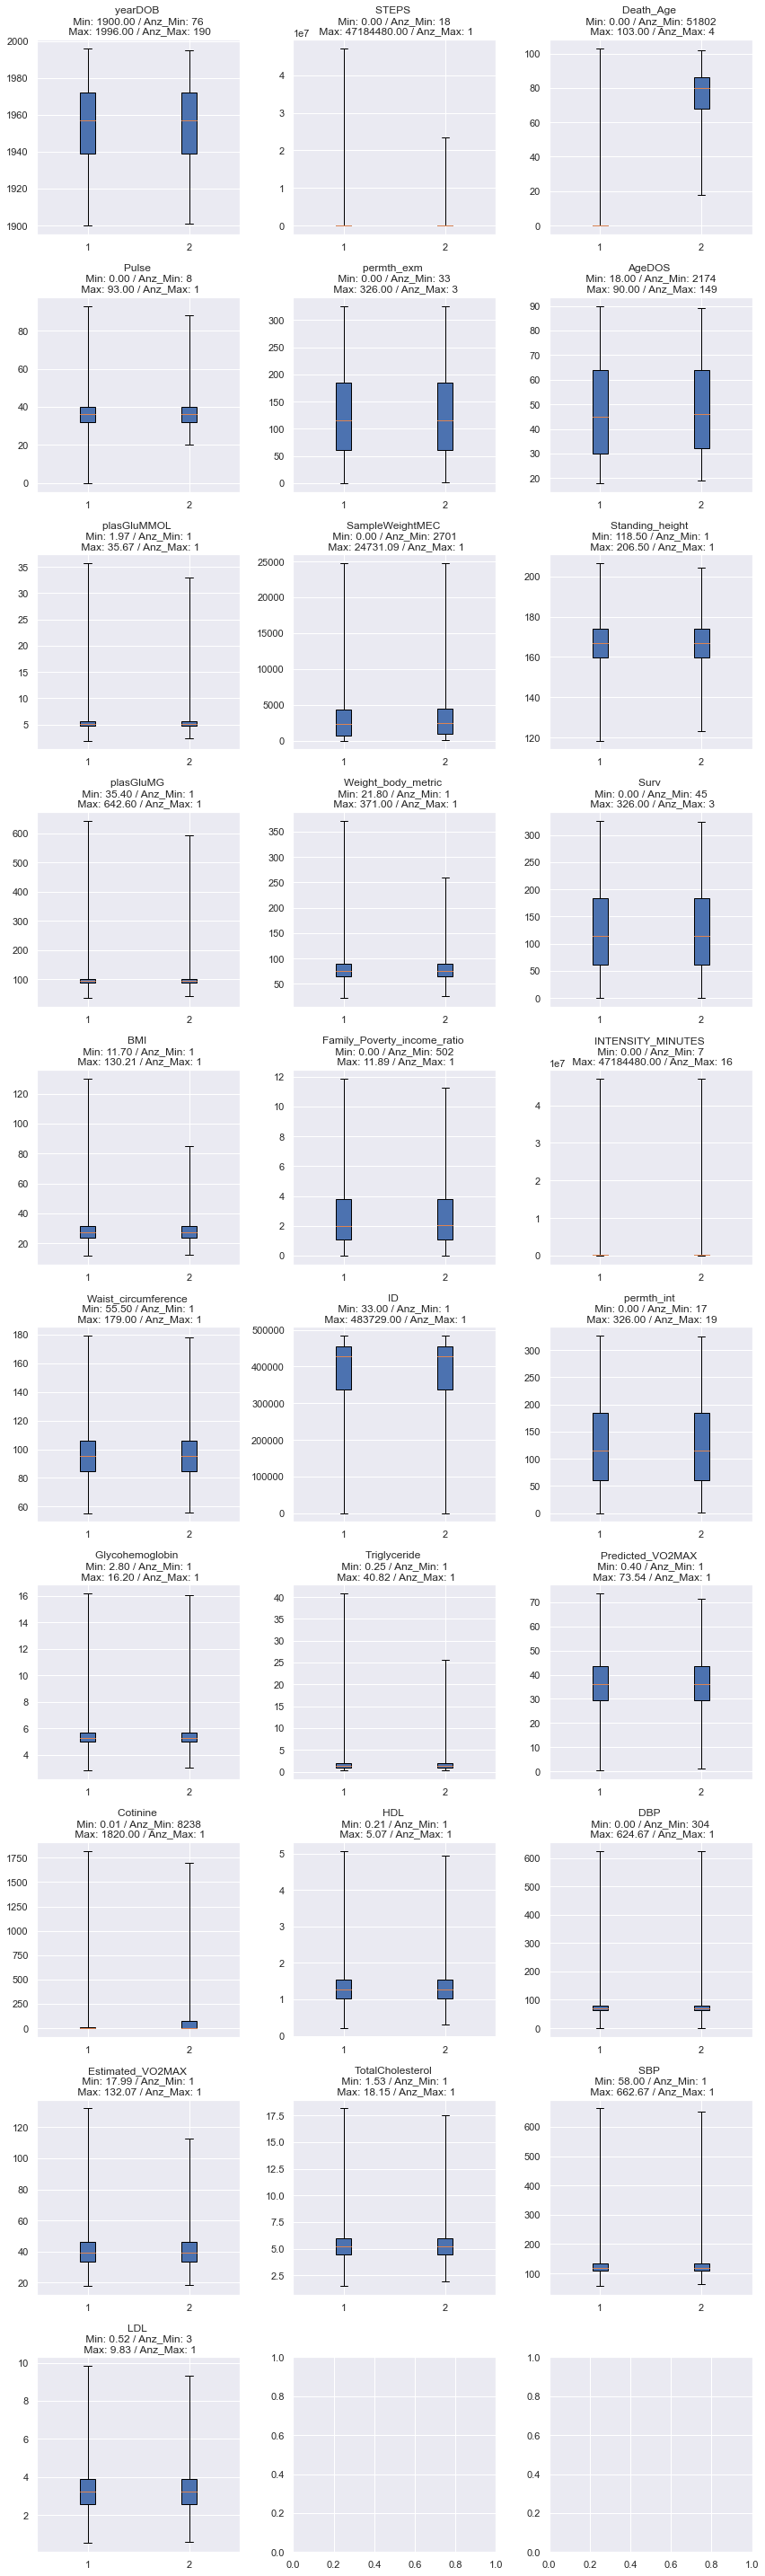

In [31]:
n_rows = 10
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize = (n_cols*4, n_rows*4))

for r in range(0,n_rows):
    for c in range(0, n_cols):
        i = r*n_cols + c
        if i < len(num_columns):
            var = num_columns[i]
            daten = df[var].fillna(-1)[df[var]>=0]
            daten = df[var][~df[var].isnull()]
            daten_gekappt = daten[daten>min(daten)][daten<max(daten)]
            axs[r][c].boxplot([daten, daten_gekappt], sym='o', whis=[0,100], patch_artist=True)
            axs[r][c].set_title("{0} \n Min: {1:.2f} / Anz_Min: {2} \n Max: {3:.2f} / Anz_Max: {4}".format(
                                var, min(daten), sum(daten==min(daten)),
                                max(daten), sum(daten==max(daten))))

plt.tight_layout()
plt.show()

Die Grafiken zeigen bei einigen Variablen deutliche Ausreißer - z. B. bei
- Cotinine
- Triglyceride
- plasGluMMOL
- Steps
- Intensity Minutes 

Hier gilt es in Abhängigkeit der verwendeten Modelle zu überprüfen, wie damit umgegangen werden soll.